In [19]:
from tensorflow.keras.applications import VGG19, InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf
from PIL import Image
import keras
from tensorflow.keras.layers import Conv2D, Input, GlobalAveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Model, load_model, save_model

from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend

from keras import applications
from keras.models import Sequential

import numpy as np
from tensorflow.keras.utils import plot_model
import visualkeras
from PIL import ImageFont
from tensorflow.keras.layers import Concatenate

from model import CNN1, CNN2, Finetuning
import yaml
from data_loader import test_generation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from PIL import Image
import imutils
from kapur import kapur_threshold

from preprocessing import visualize_preprocessing
from data_loader import visualize_augmentation
from visualize import plot_graphs

### 1. Visualization of Preprocessing

### visualization data augmentation
1. Performs a random rotation of the image with an angle range of ±90 degrees.
2. Perform a random shear transform on the image with a shear strength of 0.4.
3. Perform random vertical flips.
4. Perform random horizontal flips.
5. Standardize each sample by subtracting the mean and dividing by the standard deviation for each pixel.

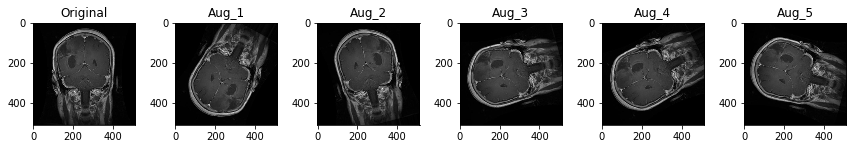

In [4]:
visualize_augmentation("data\\visualization\\glioma", "data\\aug_visualization\\glioma", sample_name="Tr-gl_0010", num_augmentations=5)

### visualization masked processing

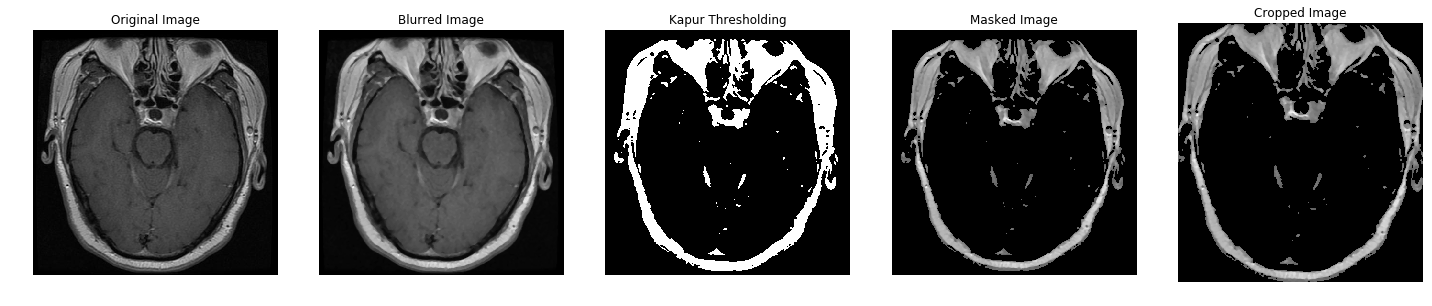

In [14]:
visualize_preprocessing("data\\Training", "data\\Processed_Training", masking=True)

### visualization unmasked processing

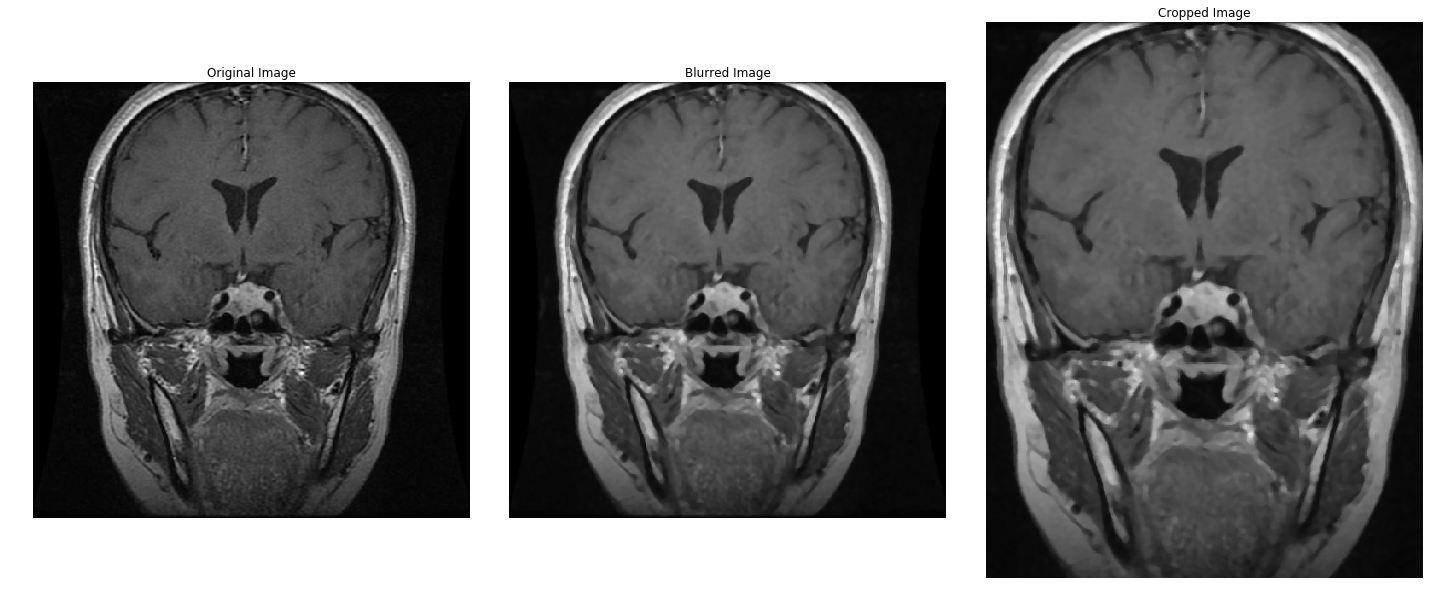

In [22]:
visualize_preprocessing("data\\Training", "data\\Unmasked_Processed_Training", masking=False)

### 2. Visualization of Confusion Matrix

The model to be evaluated is: models/masked_CNN2_aug/weights-11-0.79.h5
the test data used are stored in path: D:\project_copy\project\data\Processed_Testing
Found 1311 images belonging to 4 classes.
Model successfully built...
Weights have been loaded, now predicting...
20/20 [==============================] - 10s 479ms/step
Precision: 0.7364349359223707 

Recall: 0.6801452432824981 


Accuracy is 0.700229


<Figure size 7200x4800 with 0 Axes>

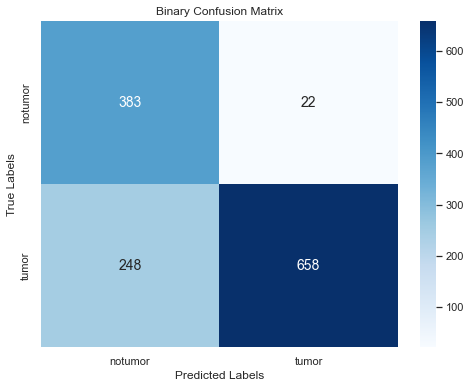

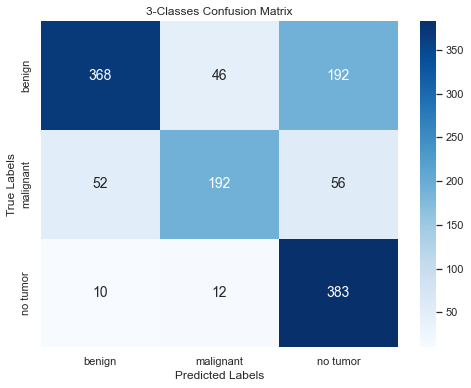

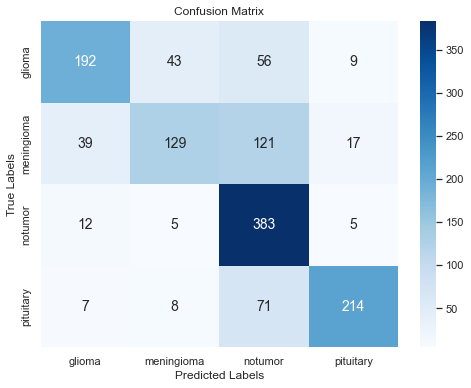

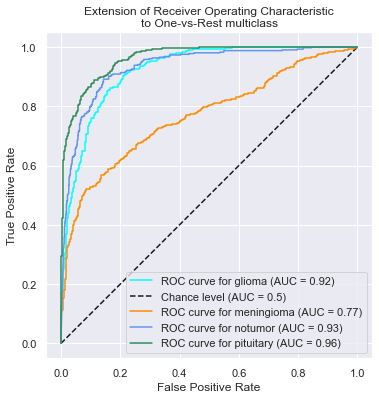

In [24]:
%run evaluate.py --path models/masked_CNN2_aug/weights-11-0.79.h5

The model to be evaluated is: models/masked_inceptionv3_aug/weights-12-0.76.h5
the test data used are stored in path: D:\project_copy\project\data\Processed_Testing
Found 1311 images belonging to 4 classes.
Model successfully built...
Weights have been loaded, now predicting...
20/20 [==============================] - 41s 2s/step
Precision: 0.7061810543953402 

Recall: 0.6612236746550472 


Accuracy is 0.684973


<Figure size 7200x4800 with 0 Axes>

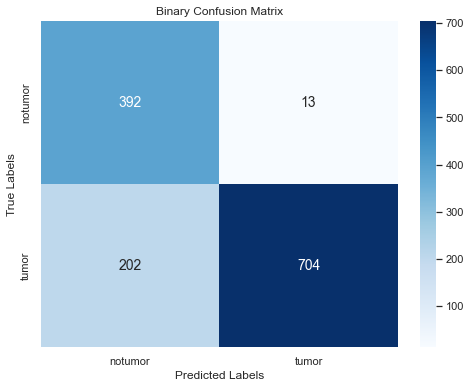

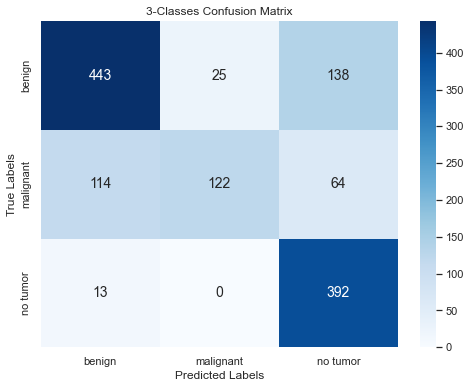

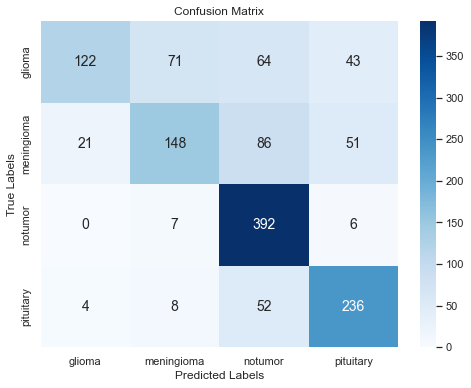

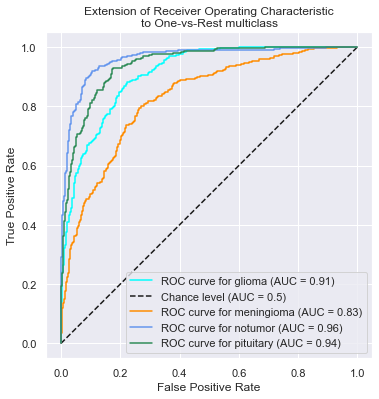

In [26]:
%run evaluate.py --path models/masked_inceptionv3_aug/weights-12-0.76.h5

### 3. Visualization of Models

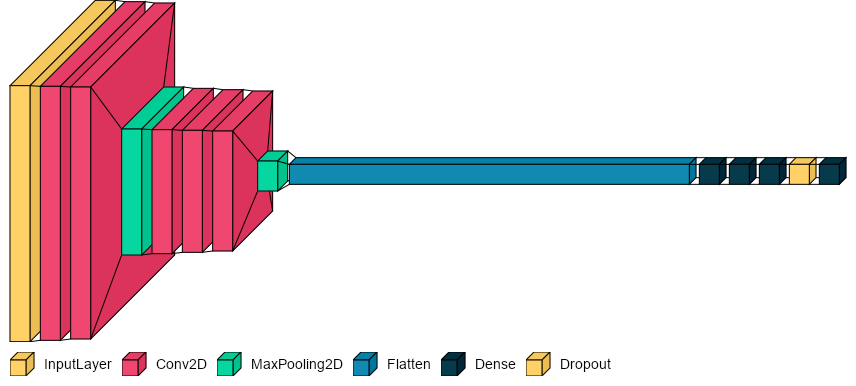

In [4]:
# CNN1
# Creating the structure of a CNN1 model using the Functional APIs
input_tensor = tf.keras.Input(shape=(256, 256, 1))

x = Conv2D(16, kernel_size=(3,3), activation='relu')(input_tensor)
x = Conv2D(32, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D(2,2)(x)
x = Conv2D(32, kernel_size=(3,3), activation='relu')(x)
x = Conv2D(32, kernel_size=(3,3), activation='relu')(x)
x = Conv2D(64, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D(4,4)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dropout(rate=0.5)(x)
output_tensor = Dense(4, activation='softmax')(x)

functional_cnn1 = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# Visualization
font = ImageFont.truetype("arial.ttf", 14)  
visualkeras.layered_view(functional_cnn1, legend=True, font=font, scale_xy=1)

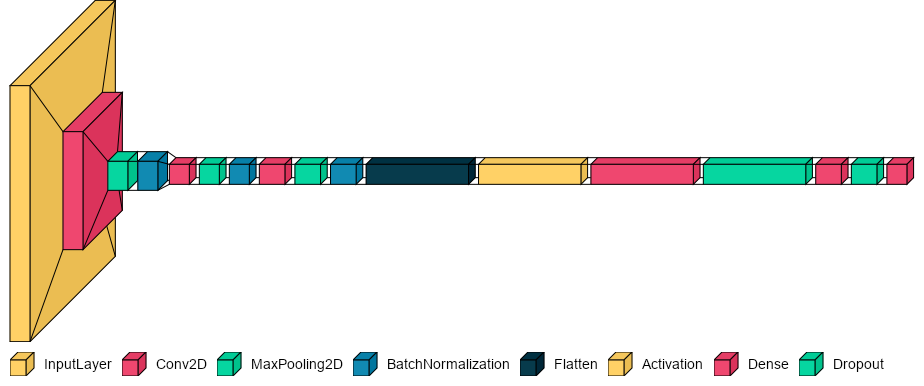

In [5]:
# CNN2
input_tensor = tf.keras.Input(shape=(256, 256, 1))

x = Conv2D(64, kernel_size=(22,22), strides=2)(input_tensor)
x = MaxPool2D(4,4)(x)
x = BatchNormalization()(x)

x = Conv2D(128, kernel_size=(11,11), strides=2, padding="same")(x)
x = MaxPool2D(2,2)(x)
x = BatchNormalization()(x)

x = Conv2D(256, kernel_size=(7,7), strides=2, padding="same")(x)
x = MaxPool2D(2,2)(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Activation("relu")(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.4)(x)
output_tensor = Dense(4, activation='softmax')(x)

functional_cnn2 = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# Visualization
font = ImageFont.truetype("arial.ttf", 14)  
visualkeras.layered_view(functional_cnn2, legend=True, font=font, scale_xy=1)

In [14]:
def create_vgg19(input_shape=(256, 256, 1)):
    # Load the VGG19 model with pretrained weights and exclude the top (classification) layers
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))
    
    # Get the configuration of the VGG19 model
    cfg = base_model.get_config()
    
    # Modify the input shape of the first layer to accept single-channel images
    cfg['layers'][0]['config']['batch_input_shape'] = (None, input_shape[0], input_shape[1], 1)
    
    # Reconstruct the model from the modified configuration
    modified_model = Model.from_config(cfg)
    
    # Modify the weights of the first convolutional layer by averaging over the channel dimension
    new_weights = np.reshape(base_model.get_weights()[0].sum(axis=2) / 3, (3, 3, 1, 64))
    weights = base_model.get_weights()
    weights[0] = new_weights
    
    # Set the modified weights to the reconstructed model
    modified_model.set_weights(weights)
    
    return modified_model

In [7]:
# Simplified inceptionv3
def create_inceptionv3(input_shape=(256, 256, 3)):
    input_tensor = Input(shape=input_shape)

    # Inception module example
    # Branch 1: 1x1 conv
    branch1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_tensor)

    # Branch 2: 1x1 conv -> 3x3 conv
    branch2 = Conv2D(64, (1,1), padding='same', activation='relu')(input_tensor)
    branch2 = Conv2D(128, (3,3), padding='same', activation='relu')(branch2)

    # Branch 3: 1x1 conv -> 5x5 conv
    branch3 = Conv2D(64, (1,1), padding='same', activation='relu')(input_tensor)
    branch3 = Conv2D(128, (5,5), padding='same', activation='relu')(branch3)

    # Branch 4: 3x3 max pooling -> 1x1 conv
    branch4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_tensor)
    branch4 = Conv2D(128, (1,1), padding='same', activation='relu')(branch4)

    # Concatenate branches
    x = Concatenate()([branch1, branch2, branch3, branch4])

    # ... Can add more Inception modules or other layers

    model = Model(inputs=input_tensor, outputs=x)
    return model

In [31]:
def create_inceptionv3(input_shape=(256, 256, 1)):
    # Load the InceptionV3 model with pretrained weights and exclude the top (classification) layers
    weights_path = 'others\\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    base_model = InceptionV3(weights=weights_path, include_top=False, input_shape=(input_shape[0], input_shape[1], 3))
    
    # Get the configuration of the InceptionV3 model
    cfg = base_model.get_config()
    
    # Modify the input shape of the first layer to accept single-channel images
    cfg['layers'][0]['config']['batch_input_shape'] = (None, input_shape[0], input_shape[1], 1)
    
    # Reconstruct the model from the modified configuration
    modified_model = Model.from_config(cfg)
    
    # Modify the weights of the first convolutional layer by averaging over the channel dimension
    new_weights = np.reshape(base_model.get_weights()[0].sum(axis=2) / 3, (3, 3, 1, 32))
    weights = base_model.get_weights()
    weights[0] = new_weights
    
    # Set the modified weights to the reconstructed model
    modified_model.set_weights(weights)
    
    return modified_model

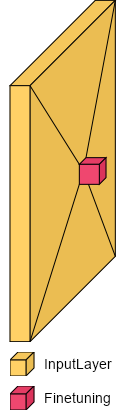

In [35]:
# Finetuning Model
class Finetuning(tf.keras.Model):

    def __init__(self, transfer, input_shape):
        super().__init__()
        self.img_size = input_shape[0]

        if transfer == "VGG19":
            self.base_model = create_vgg19(input_shape=(self.img_size, self.img_size, 3))
        elif transfer == "InceptionV3":
            self.base_model = create_inceptionv3(input_shape=(self.img_size, self.img_size, 3))

        # Add a global average pooling layer, followed by dense layers
        self.pooling1 = GlobalAveragePooling2D()   
        self.dense1 = Dense(512, activation='relu') 
        self.dense2 = Dense(4, activation='softmax')    

    def call(self, inputs):
        x = self.base_model(inputs)
        x = self.pooling1(x)
        x = self.dense1(x)
        output = self.dense2(x)
        return output


# Building Finetuning Models
transfer_model_name = "VGG19"  # "VGG19" or "InceptionV3"
finetuning_model = Finetuning(transfer_model_name, (256, 256, 1))

# Using the Functional API to create an equivalent model for visualization
input_tensor = Input(shape=(256, 256, 1))
x = finetuning_model(input_tensor)
functional_finetuning = Model(inputs=input_tensor, outputs=x)

# Visualization
font = ImageFont.truetype("arial.ttf", 14)  
visualkeras.layered_view(functional_finetuning, legend=True, font=font, scale_xy=1)

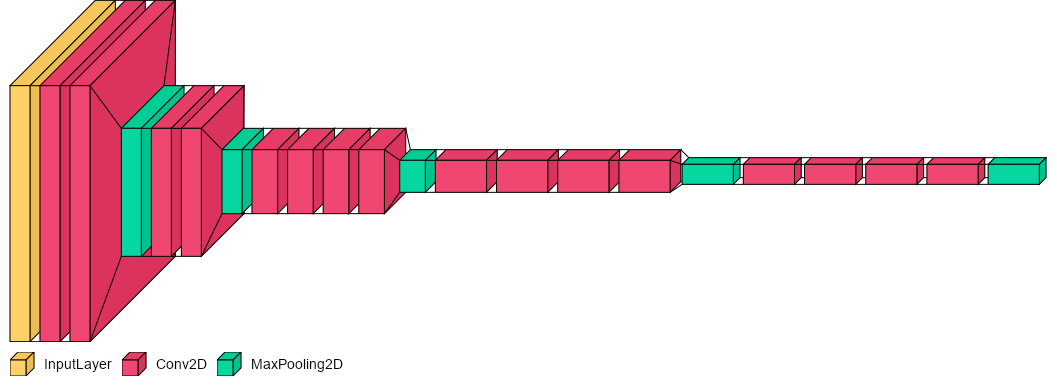

In [15]:
# VGG19
vgg19_model = create_vgg19(input_shape=(256, 256, 1))

# Visualization
font = ImageFont.truetype("arial.ttf", 14)  
visualkeras.layered_view(vgg19_model, legend=True, font=font, scale_xy=1)



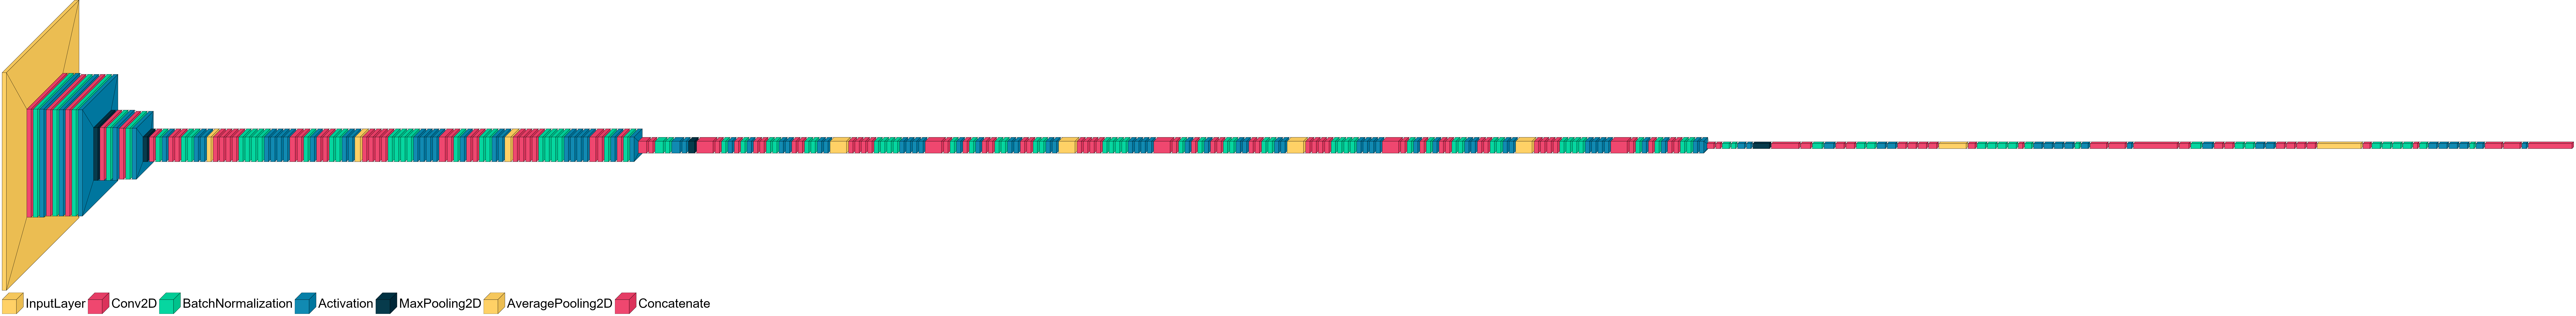

In [33]:
# InceptionV3
inceptionv3_model = create_inceptionv3(input_shape=(256, 256, 1))

# Visualization
font = ImageFont.truetype("arial.ttf", 60)  
visualkeras.layered_view(inceptionv3_model, legend=True, font=font)

### 4. Visualization of Accuracy & Loss

### Accuracy & Loss for different types of models

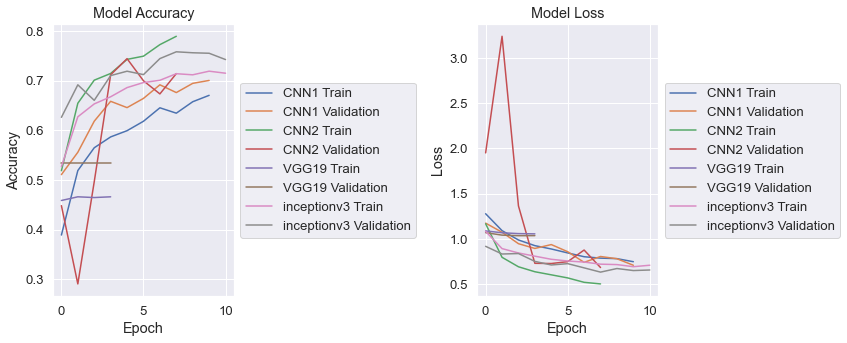

In [8]:
model_names1 = ['CNN1', 'CNN2', 'VGG19', 'inceptionv3']
plot_graphs(model_names1)

### Accuracy & Loss for model trained on different types of train set

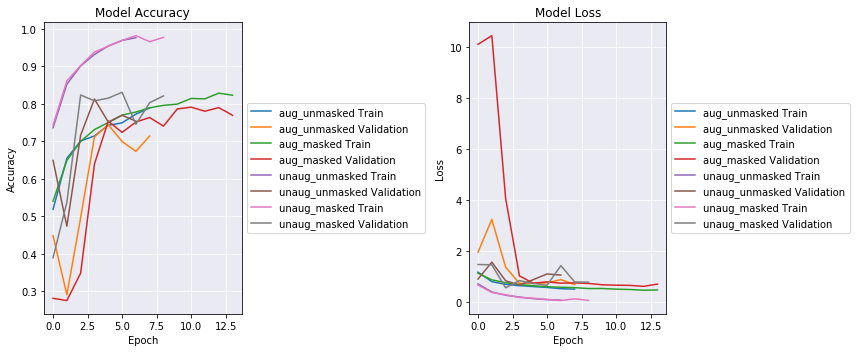

In [2]:
model_names2 = ['aug_unmasked', 'aug_masked', 'unaug_unmasked', 'unaug_masked']
plot_graphs(model_names2)

In [9]:
model_names1 = ['CNN1', 'CNN2', 'VGG19', 'inceptionv3']
model_names2 = ['aug_unmasked', 'aug_masked', 'unaug_unmasked', 'unaug_masked'] #CNN2
import seaborn as sns
import itertools

def plot_one_graph(model_name):
    # Read the contents of JSON file
    with open(f'json/history_{model_name}.json', 'r') as file:
        data = json.load(file)

    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.lineplot(data=list(data['accuracy'].values()))
    sns.lineplot(data=list(data['val_accuracy'].values()))
#     plt.plot(list(data['accuracy'].values()))
#     plt.plot(list(data['val_accuracy'].values()))
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(list(data['loss'].values()))
    plt.plot(list(data['val_loss'].values()))
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


def plot_graphs(model_names, title = 'Model Accuracy Under Different Processing Methods', file_name = "Processing.pdf"):
    plt.figure(dpi=1200)
    palette = itertools.cycle(sns.color_palette())
    plt.figure(figsize=(14, 6))
    model_names = model_names
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    for model_name in model_names:
        with open(f'json/history_{model_name}.json', 'r') as file:
            data = json.load(file)
        x = range(0, len(list(data['accuracy'].values())))
        col = color=next(palette)
        sns.lineplot(x = x,  y=list(data['accuracy'].values()),  marker='o', linewidth = 2,label = f'{model_name} Train', color = col)
        sns.lineplot(x = x ,y=list(data['val_accuracy'].values()), linestyle='--', linewidth = 2,marker='o',label=f'{model_name} Validation', color = col)
#         plt.plot(list(data['accuracy'].values()), label=f'{model_name} Train')
#         plt.plot(list(data['val_accuracy'].values()), label=f'{model_name} Validation')
    plt.title('Accuracy %s'%title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.grid(True, color='white')  # Add white grid lines
    plt.gca().set_facecolor('#EAEAF2')  # Set background color to light gray

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    palette2 = itertools.cycle(sns.color_palette())
    
    for model_name in model_names:
        col = next(palette2)
        with open(f'json/history_{model_name}.json', 'r') as file:
            data = json.load(file)
#         plt.plot(list(data['loss'].values()), label=f'{model_name} Train')
#         plt.plot(list(data['val_loss'].values()), label=f'{model_name} Validation')
        x = range(0, len(list(data['loss'].values())))
        sns.lineplot(x = x,  y=list(data['loss'].values()), marker='o',label = f'{model_name} Train', color = col)
        sns.lineplot(x = x ,y=list(data['val_loss'].values()), linestyle='--', marker='o',label=f'{model_name} Validation', color = col)
    plt.title('Loss %s'%title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid(True, color='white')  # Add white grid lines
    plt.gca().set_facecolor('#EAEAF2')  # Set background color to light gray

    plt.tight_layout()
    plt.savefig('report/%s'%file_name) 
    plt.show()
    

<Figure size 7200x4800 with 0 Axes>

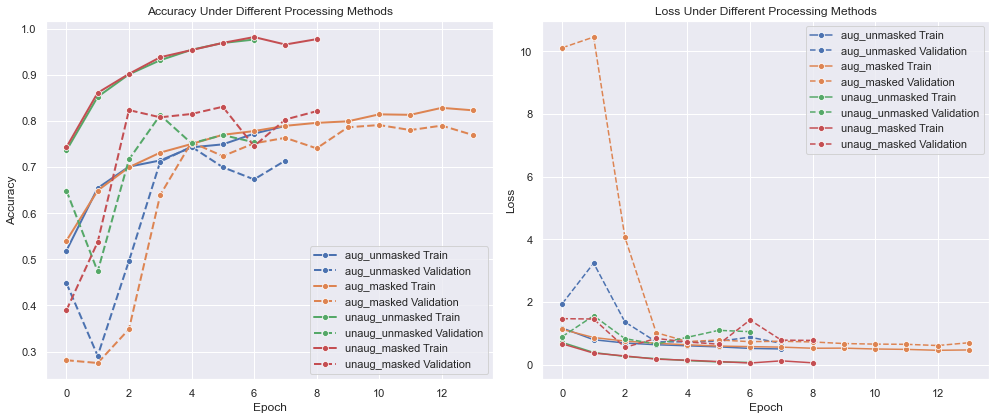

In [12]:
import json
from itertools import cycle

model_names1 = ['CNN1', 'CNN2', 'VGG19', 'inceptionv3']
model_names2 = ['aug_unmasked', 'aug_masked', 'unaug_unmasked', 'unaug_masked'] #CNN2
plot_graphs(model_names2, "Under Different Processing Methods","Processing.pdf")

<Figure size 7200x4800 with 0 Axes>

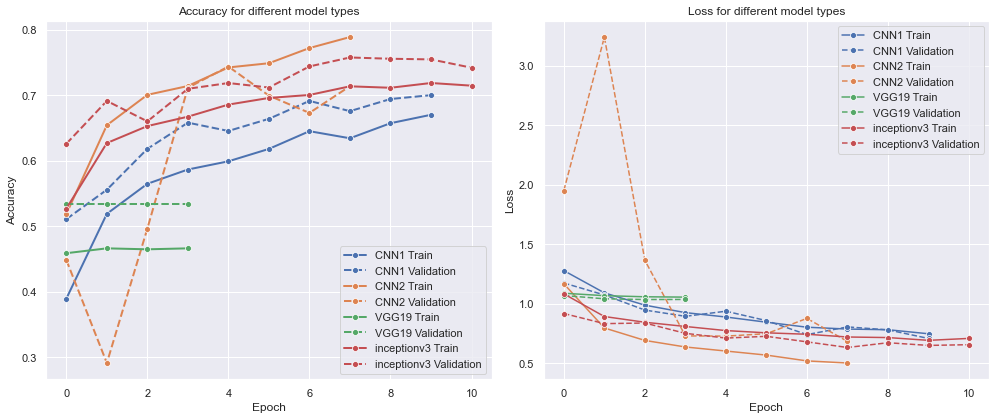

In [13]:
plot_graphs(model_names1, "for different model types","Models.pdf")
